# Machine Learning

## Imports

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, PassiveAggressiveRegressor, RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.metrics import confusion_matrix, classification_report

from joblib import dump
from joblib import load

import math

## Découpage du dataset

In [76]:
df = pd.read_csv('../csv/donnees_clean.csv')

In [77]:
X = df.drop(['charges', 'region'], axis=1)
y = df['charges']

In [78]:
X

,age,sex,bmi,children,smoker
0,19,female,27.9,0,Oui
1,18,male,33.8,1,Non
2,28,male,33.0,3,Non
3,33,male,22.7,0,Non
4,32,male,28.9,0,Non
...,...,...,...,...,...
1332,50,male,31.0,3,Non
1333,18,female,31.9,0,Non
1334,18,female,36.9,0,Non
1335,21,female,25.8,0,Non


## Nettoyage des données

In [79]:
def calcul_bmi(bmi):
    if bmi < 18.5:
        return "maigreur"
    elif bmi < 25:
        return "normal"
    elif bmi < 30:
        return "surpoids"
    elif bmi < 35:
        return "obesite_moderee"
    elif bmi < 40:
        return "obesite_severe"
    else:
        return "obesite_morbide"

In [80]:
X['bmi'] = X['bmi'].apply(lambda x : calcul_bmi(x))

X

,age,sex,bmi,children,smoker
0,19,female,surpoids,0,Oui
1,18,male,obesite_moderee,1,Non
2,28,male,obesite_moderee,3,Non
3,33,male,normal,0,Non
4,32,male,surpoids,0,Non
...,...,...,...,...,...
1332,50,male,obesite_moderee,3,Non
1333,18,female,obesite_moderee,0,Non
1334,18,female,obesite_severe,0,Non
1335,21,female,surpoids,0,Non


## Train_set & Test_set

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.80, random_state=42)
X_train

,age,sex,bmi,children,smoker
1113,23,male,normal,0,Non
967,21,male,surpoids,2,Non
598,52,female,obesite_severe,2,Non
170,63,male,obesite_morbide,0,Non
275,47,female,surpoids,2,Non
...,...,...,...,...,...
1095,51,female,obesite_severe,2,Oui
1130,27,male,obesite_morbide,2,Non
1294,20,male,normal,1,Non
860,38,female,surpoids,3,Non


## Dummy Modèle

In [82]:
dummy = DummyRegressor()

In [83]:
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.008391984006549169

## Création des Transformeurs

In [84]:
cat_var = ['smoker', 'sex', 'bmi']
num_var = ['age', 'children']

cat_transformer = OneHotEncoder(drop='if_binary')
num_transformer = RobustScaler()

encoder = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var),
        ('num', num_transformer, num_var)
    ], 
    remainder='passthrough'
)

## Modèles

### Résultats avec hyperparamètres sélectionnés

In [85]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []

models = [
    Lasso(alpha=0.9, positive=True, precompute=True, warm_start=True, selection='cyclic'),
    Ridge(alpha=0.3, solver='auto'),
    ElasticNet(alpha=0.1, l1_ratio=0.9, positive=True, precompute=True, selection='random', warm_start=True),
    # ARDRegression(threshold_lambda=10000, lambda_2=1e-05, lambda_1=5e-05, fit_intercept=False, copy_X=True, compute_score=False, alpha_2=7e-05, alpha_1=2e-05),
    BaggingRegressor(Lasso(alpha=0.9, positive=True, precompute=True, warm_start=True), n_estimators=14)
    ]

list_voting = []

for model in models:
    list_voting.append((f"{model.__class__.__name__}", model))

voting = StackingRegressor(list_voting, models[0])

models.append(voting)

list_models = []


for model in models:
    pipe = Pipeline([
        ('enc', encoder), 
        ('poly', PolynomialFeatures()), 
        ('model', model),
    ])

    for train_index, test_index in kf.split(X_train):
        
        Xx_train, Xx_test = X.iloc[train_index], X.iloc[test_index]
        Yy_train, Yy_test = y.iloc[train_index], y.iloc[test_index]
        
        pipe.fit(Xx_train, Yy_train)

        score = pipe.score(Xx_test, Yy_test)
        scores.append(score)

    mean_score = np.mean(scores)

    prediction = pipe.predict(Xx_test)
    score_rmse = math.sqrt(mean_squared_error(Yy_test, prediction))

    list_models.append([f"{model.__class__.__name__}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])

    print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(mean_score *100, 2)}%, RMSE score : {round(score_rmse,2)}")

    dump(pipe, f"../models/{model.__class__.__name__}.pkl")

Nom du modèle : Lasso, R2 score : 85.49%, RMSE score : 5379.03
Nom du modèle : Ridge, R2 score : 85.44%, RMSE score : 5356.86
Nom du modèle : ElasticNet, R2 score : 84.68%, RMSE score : 5437.37
Nom du modèle : BaggingRegressor, R2 score : 84.87%, RMSE score : 5367.83


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37180080.538238525, tolerance: 13957598.818259206
  model = cd_fast.enet_coordinate_descent_gram(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29196568.386390686, tolerance: 14185007.715650449
  model = cd_fast.enet_coordinate_descent_gram(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36215824.88951874, tolerance: 14377132.621580219
  model = cd_fast.enet_coordinate_descent_gram(


Nom du modèle : StackingRegressor, R2 score : 84.97%, RMSE score : 5381.36


In [86]:
df_list_models = pd.DataFrame(list_models,columns=['modele', "r2_score", "score_rmse"])

df_list_models.sort_values('r2_score', ascending=False)

,modele,r2_score,score_rmse
1,Ridge,81.57%,5356.86
3,BaggingRegressor,81.5%,5367.83
0,Lasso,81.42%,5379.03
4,StackingRegressor,81.4%,5381.36
2,ElasticNet,81.01%,5437.37


In [87]:
le_modele = load('../models/Ridge.pkl')

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 430, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 719, in score
    Xt = transform.transform(Xt)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 799, in transform

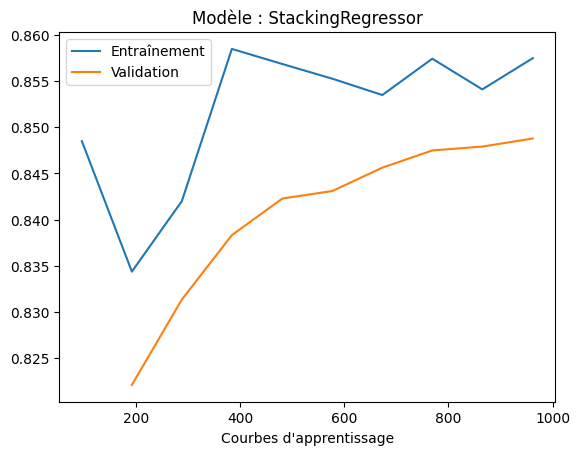

In [88]:
N, train_score, val_score = learning_curve(le_modele, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=10)

plt.plot(N, train_score.mean(axis=1), label='Entraînement')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.title(f"Modèle : {model.__class__.__name__}")
plt.xlabel('Courbes d\'apprentissage')
plt.legend()
plt.show()

## Calcul des résidus

In [89]:
predicts = le_modele.predict(X_train)

residus = y_train - predicts

predicts

array([ 3603.80651382,  5104.35454915, 13169.65572897, ...,
        3931.66766506,  9407.12202047,  8435.24396919])

In [90]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
residus.reset_index(drop=True, inplace=True)

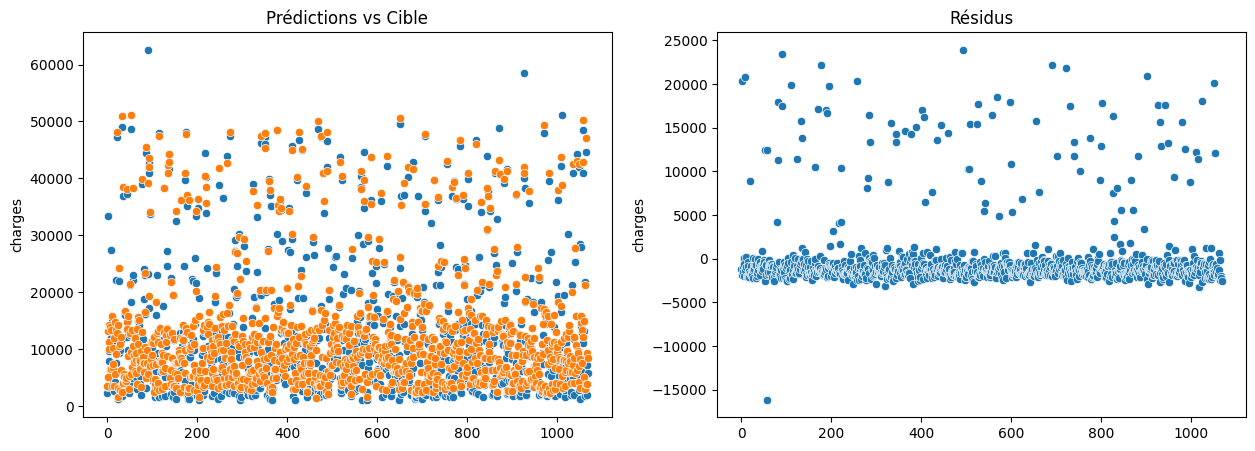

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.scatterplot(y_train)
sns.scatterplot(predicts)
plt.title("Prédictions vs Cible")

plt.subplot(1, 2, 2)
sns.scatterplot(residus)
plt.title("Résidus")
plt.show()

In [92]:
TRAINING = pd.concat([X_train, y_train], axis=1)

TRAINING.reset_index(drop=True, inplace=True)

TRAINING

,age,sex,bmi,children,smoker,charges
0,23,male,normal,0,Non,2396.10
1,21,male,surpoids,2,Non,3279.87
2,52,female,obesite_severe,2,Non,33471.97
3,63,male,obesite_morbide,0,Non,13405.39
4,47,female,surpoids,2,Non,9715.84
...,...,...,...,...,...,...
1064,51,female,obesite_severe,2,Oui,44641.20
1065,27,male,obesite_morbide,2,Non,3693.43
1066,20,male,normal,1,Non,1964.78
1067,38,female,surpoids,3,Non,7151.09


In [93]:
TRAINING['residus'] = residus
TRAINING['residus'] = TRAINING['residus'].apply(lambda x : -x if x < 0 else x)

TRAINING

,age,sex,bmi,children,smoker,charges,residus
0,23,male,normal,0,Non,2396.10,1207.706514
1,21,male,surpoids,2,Non,3279.87,1824.484549
2,52,female,obesite_severe,2,Non,33471.97,20302.314271
3,63,male,obesite_morbide,0,Non,13405.39,913.266941
4,47,female,surpoids,2,Non,9715.84,1482.249573
...,...,...,...,...,...,...,...
1064,51,female,obesite_severe,2,Oui,44641.20,2421.148568
1065,27,male,obesite_morbide,2,Non,3693.43,114.260618
1066,20,male,normal,1,Non,1964.78,1966.887665
1067,38,female,surpoids,3,Non,7151.09,2256.032020


In [94]:
# X_train = encoder.transform(X_train)

# X_train

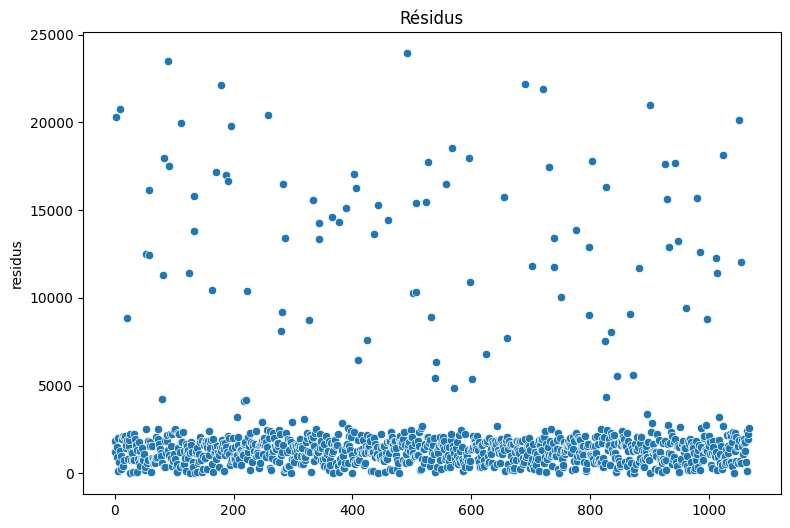

In [95]:
plt.figure(figsize=(9,6))
sns.scatterplot(TRAINING['residus'])
plt.title("Résidus")
plt.show()

In [96]:
p = X_train.shape[1]
n = X_train.shape[0]

TRAINING['distance_cook'] = residus**2 / (p + 1) * (1 - le_modele.score(X_train, y_train)) / (X_train.shape[0] - p - 1)

# # Compute the leverage
# leverage = (X_train @ np.linalg.inv(X_train.T @ X_train)) @ X_train.T

# # Compute the Cook's distance
# cooks_distance = (residus**2 / (n * le_modele.scale_)) * leverage.diagonal()

# # Add the Cook's distance to the training data
# TRAINING['cooks_distance'] = cooks_distance

TRAINING

,age,sex,bmi,children,smoker,charges,residus,distance_cook
0,23,male,normal,0,Non,2396.10,1207.706514,33.224598
1,21,male,surpoids,2,Non,3279.87,1824.484549,75.825853
2,52,female,obesite_severe,2,Non,33471.97,20302.314271,9389.187582
3,63,male,obesite_morbide,0,Non,13405.39,913.266941,18.999072
4,47,female,surpoids,2,Non,9715.84,1482.249573,50.047178
...,...,...,...,...,...,...,...,...
1064,51,female,obesite_severe,2,Oui,44641.20,2421.148568,133.530293
1065,27,male,obesite_morbide,2,Non,3693.43,114.260618,0.297393
1066,20,male,normal,1,Non,1964.78,1966.887665,88.124372
1067,38,female,surpoids,3,Non,7151.09,2256.032020,115.938437


In [97]:
# seuil = 4/n
seuil = 5500

# outliers = TRAINING[TRAINING['distance_cook'] > seuil].index

TRAINING['seuil'] = seuil

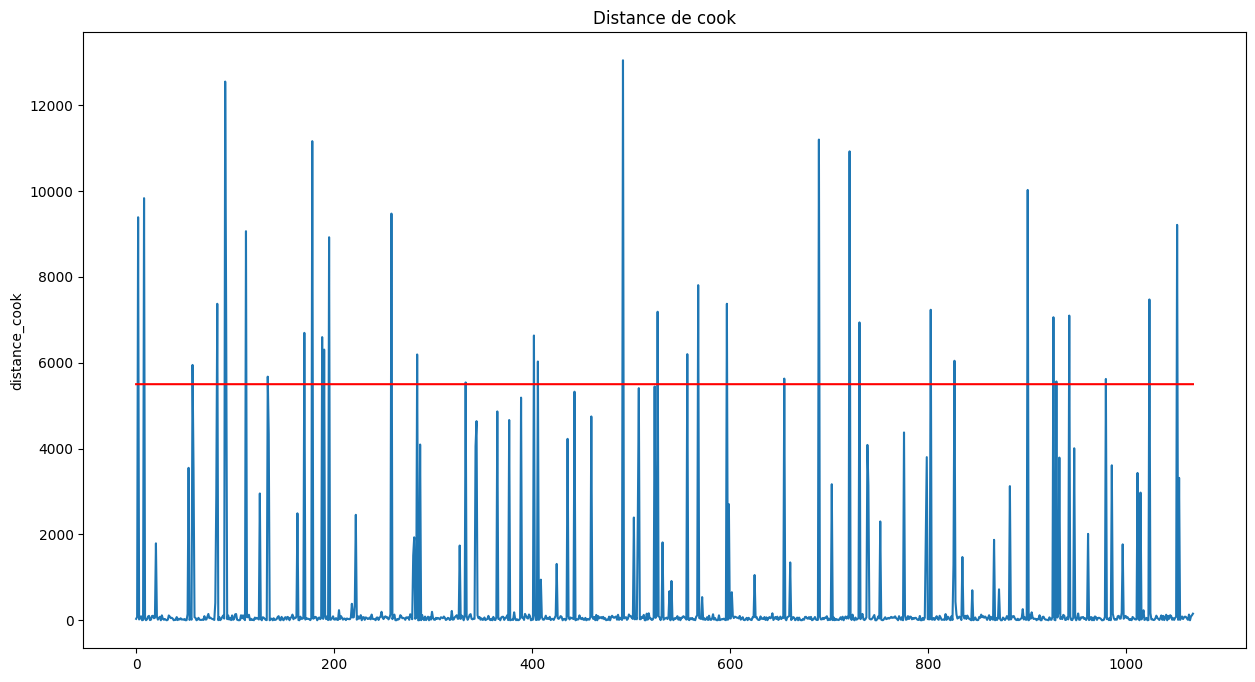

In [98]:
plt.figure(figsize=(15,8))
sns.lineplot(TRAINING['distance_cook'])
sns.lineplot(TRAINING['seuil'], color='red')
plt.title("Distance de cook")
plt.show()

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro 
from scipy.stats import kstest
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import probplot
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

def get_index_to_remove_by_Cooks_Distance(X_train, y_train, preprocessor):
    """
    This function removes observations from the training data that have high Cook's distance values.
    Cook's distance is a measure of the influence of an observation on a statistical model.
    Observations with high Cook's distance values may have a disproportionate influence on the model,
    and removing them can improve the model's accuracy.
    
    Parameters:
    - X_train: pd.DataFrame
        The training data
    - y_train: pd.Series
        The target labels for the training data
    - preprocessor: sklearn.compose.ColumnTransformer
        The preprocessor created by make_pipeline_to_ML()
        
    Returns:
    - index_to_be_removed: pd.Index
        The indices of the observations to be removed from the training data
    """
    
    # Fit the transformer to the training data
    preprocessor.fit(X_train)
    
    # Transform the training data using the preprocessor
    X_test_pipe = preprocessor.transform(X_train)
    
    # Get the names of the columns added by the OneHotEncoder
    new_columns = preprocessor.get_feature_names_out()
    new_columns = [w.replace('pipeline-1__', '') for w in new_columns]
    new_columns = [w.replace('pipeline-2__', '') for w in new_columns]
    
    # Convert the transformed data to a Pandas DataFrame
    newdf = pd.DataFrame(X_test_pipe)
    
    # Set the column names to the names obtained from the OneHotEncoder
    newdf.columns = new_columns
    
    # Add a constant term to the DataFrame
    X = sm.add_constant(newdf)
    
    # Set the index of the DataFrame to the index of the target labels
    X = X.set_index(y_train.index)
    
    # Fit an OLS model to the data
    estimation = sm.OLS(y_train, X_test_pipe).fit()
    
    # Calculate the Cook's distance values for each observation
    influence = estimation.get_influence().cooks_distance[0]
    
    # Add the Cook's distance values to the DataFrame as a new column
    X['dcooks'] = influence
    
    # Calculate the threshold for Cook's distance values
    n = X.shape[0]
    p = X.shape[1]
    seuil_dcook = 4/(n-p)
    
    # Select the indices of the observations with Cook's distance values above the threshold
    index_to_be_removed = X[X['dcooks']>seuil_dcook].index
    
    plt.figure(figsize=(10,6))
    plt.bar(X.index, X['dcooks'])
    plt.xticks(np.arange(0, len(X), step=int(len(X)/10)))
    plt.xlabel('Observation')
    plt.ylabel('Cooks Distance')
    #Plot the line
    plt.hlines(seuil_dcook, xmin=0, xmax=len(X_train), color='r')
    plt.show()


    # Return the indices of the observations to be removed
    return index_to_be_removed

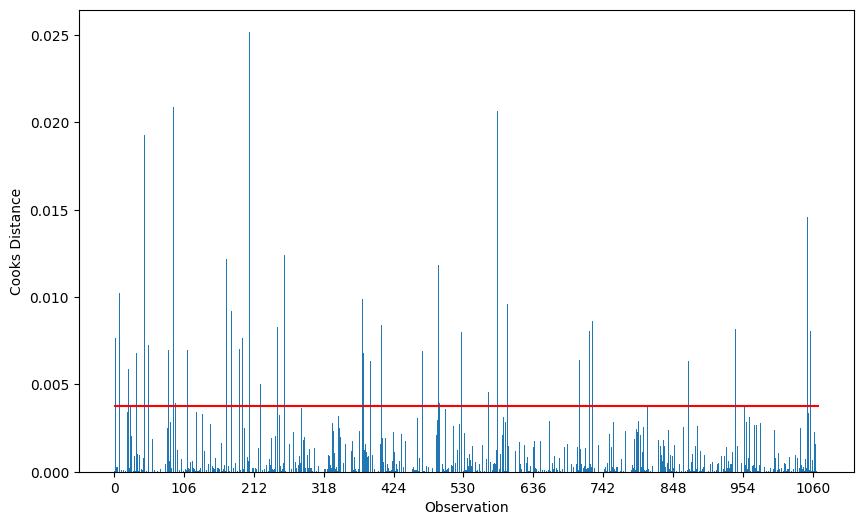

In [100]:
index_to_be_removed = get_index_to_remove_by_Cooks_Distance(X_train, y_train, encoder)

## Réentrainement du modèle

In [101]:
# df_final = TRAINING.drop(index=index_to_be_removed.values, axis=0)
# df_final = TRAINING[TRAINING['residus'] < 5000]
df_final = TRAINING[TRAINING['distance_cook'] < TRAINING['seuil']]

df_final.drop(['residus'], axis=1, inplace=True)

df_final

/tmp/ipykernel_66315/2902517250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop(['residus'], axis=1, inplace=True)


,age,sex,bmi,children,smoker,charges,distance_cook,seuil
0,23,male,normal,0,Non,2396.10,33.224598,5500
1,21,male,surpoids,2,Non,3279.87,75.825853,5500
3,63,male,obesite_morbide,0,Non,13405.39,18.999072,5500
4,47,female,surpoids,2,Non,9715.84,50.047178,5500
5,41,female,obesite_moderee,3,Non,7954.52,93.050004,5500
...,...,...,...,...,...,...,...,...
1064,51,female,obesite_severe,2,Oui,44641.20,133.530293,5500
1065,27,male,obesite_morbide,2,Non,3693.43,0.297393,5500
1066,20,male,normal,1,Non,1964.78,88.124372,5500
1067,38,female,surpoids,3,Non,7151.09,115.938437,5500


In [102]:
X_final = df_final.drop(['charges','distance_cook','seuil'], axis=1)
y_final = df_final['charges']

X_final = pd.DataFrame(X_final)
y_final = pd.Series(y_final)

In [103]:
X_final

,age,sex,bmi,children,smoker
0,23,male,normal,0,Non
1,21,male,surpoids,2,Non
3,63,male,obesite_morbide,0,Non
4,47,female,surpoids,2,Non
5,41,female,obesite_moderee,3,Non
...,...,...,...,...,...
1064,51,female,obesite_severe,2,Oui
1065,27,male,obesite_morbide,2,Non
1066,20,male,normal,1,Non
1067,38,female,surpoids,3,Non


In [104]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = []

# for train_index, test_index in kf.split(X_final):
    
#     Xx_train, Xx_test = X_final.iloc[train_index], X_final.iloc[test_index]
#     Yy_train, Yy_test = y_final.iloc[train_index], y_final.iloc[test_index]
    
#     le_modele.fit(Xx_train, Yy_train)
#     score = le_modele.score(Xx_test, Yy_test)
#     scores.append(score)

# mean_score = np.mean(scores)
# prediction = le_modele.predict(Xx_test)
# score_rmse = math.sqrt(mean_squared_error(Yy_test, prediction))

# print(f"Nom du modèle : {le_modele.__class__.__name__}, R2 score : {round(mean_score *100, 2)}%, RMSE score : {round(score_rmse,2)}")
# print(scores)

# dump(le_modele, f"../models/{le_modele.__class__.__name__}.pkl")

In [105]:
le_modele.fit(X_final, y_final)

score = cross_val_score(le_modele, X_final, y_final,cv=5).mean()

prediction = le_modele.predict(X_final)
score_rmse = math.sqrt(mean_squared_error(y_final, prediction))

y_pred = le_modele.predict(X_final)

print(f"Nom du modèle : Ridge, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}")

dump(le_modele, f"../models/{le_modele.__class__.__name__}.pkl")

Nom du modèle : Ridge, R2 score : 93.38%, RMSE score : 2821.21


['../models/Pipeline.pkl']

19 h 31 fumeur nortwest 33750.29

In [106]:
groupe = df[(df['age'] == 19) & (df['sex'] == "female") & (df['region'] == "northwest") & (df['children'] == 0) & (df['smoker'] == "Oui")].sort_values('age')

groupe

,age,sex,bmi,children,smoker,region,charges
603,19,female,28.3,0,Oui,northwest,17468.98
772,19,female,28.9,0,Oui,northwest,17748.51
1138,19,female,32.5,0,Oui,northwest,36898.73
1195,19,female,30.0,0,Oui,northwest,33307.55


In [107]:
df[(df['bmi'] > 30) & (df['smoker'] == "Oui")].min()

age                18
sex            female
bmi              30.2
children            0
smoker            Oui
region      northeast
charges      32548.34
dtype: object

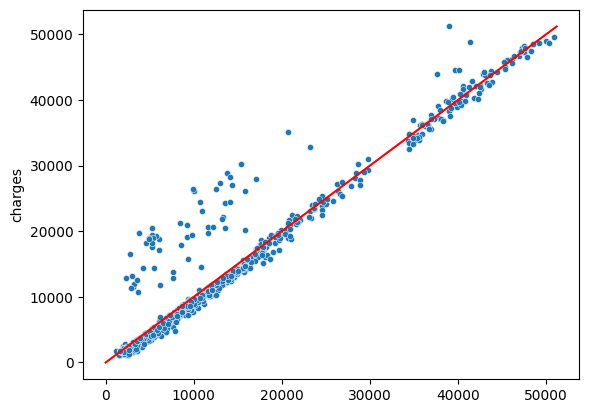

In [108]:
# jean = 17352.68

# if jean in y_final.values:
#     y_final.pop(jean)

sns.scatterplot(x=y_pred, y=y_final, s=20)
# plt.scatter(x=jean, y=jean, s=40)
plt.plot(np.arange(max(y_final.values)), np.arange(max(y_final.values)), '-', color='r')

plt.show()

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 430, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 719, in score
    Xt = transform.transform(Xt)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/apprenant/.local/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 799, in transform

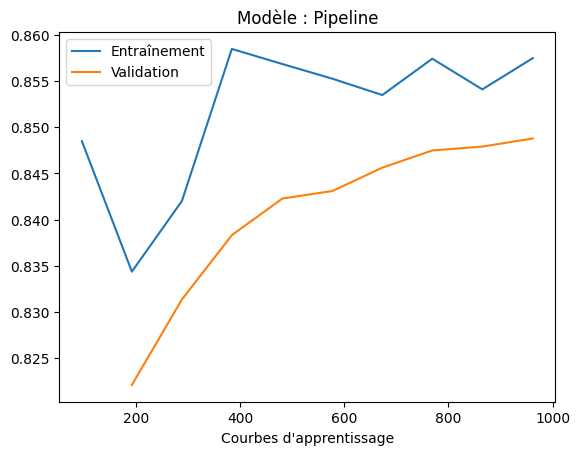

In [109]:
model = le_modele

N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=10)

plt.plot(N, train_score.mean(axis=1), label='Entraînement')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.title(f"Modèle : {model.__class__.__name__}")
plt.xlabel('Courbes d\'apprentissage')
plt.legend()
plt.show()

# Tests !

In [110]:
print(f"SCORE TEST: {round((load('../models/Pipeline.pkl').score(X_test, y_test) * 100),2)}%")
# print(f"Moyenne des scores : {round((cross_val_score(model,X_test, y_test,cv=5).mean() * 100),2)}%")

SCORE TEST: 90.14%
